In [1]:
! pip install pydicom
! pip install python-gdcm
! pip install einops


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 3.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# dcm -> Image
https://github.com/abdkhanstd/COVID-19  
위 링크의 Lung CT 2d dcm file 사용

In [ ]:
import os
import glob

import numpy as np
import cv2, pydicom
import matplotlib.pyplot as plt
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
import glob
from tqdm.notebook import tqdm
from PIL import Image

def data_scaling(x, pixel_min=-1024, pixel_max=200):
    return (x - pixel_min) / (pixel_max - pixel_min)

window_center = -600
window_width = 1600

folder_path = "/content/drive/MyDrive/Covid_PIL" # 2d dicom Image
if not os.path.exists(folder_path): 
    os.mkdir(folder_path)


paths = [i for i in glob.glob("/content/drive/MyDrive/COVIDcovid/*/*/*") if 'dcm' in i]

"""
    주어진 dcm 파일을 pydicom을 통해 이미지로 변환한다.
    pydicom을 데이터셋 내부에 사용해서 바로 불러오는 방법을 사용하려했으나,
    dataloader에서 할당된 batch size만큼 가져올때 문제가 꼭 생긴다.
    그래서 이미지로 미리 저장한 후 사용.
"""

i = 0
for i in tqdm(range(i, len(paths))):
    try :
        file_name = paths[i].split("/")[-1].split('.')[0]
        save_path = os.path.join(folder_path, file_name)
        ds = pydicom.dcmread(paths[i])
        s = int(ds.RescaleSlope)
        b = int(ds.RescaleIntercept)
        image = s * ds.pixel_array + b
        if len(image.shape) == 3:
            image = image.squeeze(0)
        image = np.clip(image, window_center - (window_width / 2), window_center + (window_width / 2))
        image = data_scaling(image, image.min(), image.max())
        image = image*255
        image = image.astype(np.uint8)
        image = Image.fromarray(image)
        image.save(f'{save_path}.jpg',"JPEG")
    except :
        # 간혹 pydicom으로 안불러지는 경우 생김.
        print(1)

# Start!

In [ ]:
# drive에서 꺼내오면 너무 많은 시간이 소요 된다.
# colab local에 올려놓자.

from tqdm.notebook import tqdm

import os
import shutil
import glob

target = "/content/all_datas"
if not os.path.exists(target):
    os.mkdir(target)
folder = "/content/drive/MyDrive/Covid_PIL"
files = os.listdir(folder)
if len(files) > 0:
    for f in tqdm(files) :
        shutil.copy2(os.path.join(folder, f), os.path.join(target, f))

## Dataset

In [2]:

import os
import glob
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from torchvision import transforms

class LungImageDataset(torch.utils.data.Dataset):
    def __init__(self, transform=None): # transform 적용 시, ToTensor 먼저.
        super().__init__()
        self.paths = glob.glob("/content/all_datas/*")
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        now_path = self.paths[idx]
        image = Image.open(now_path)

        if self.transform :
            image = self.transform(image)

        return image

## Model : Unet
Official과 최대한 비슷하게 맞춰보려 했으나 코랩 프로로 돌리기 만만치않았음.  
그래서 official의 unet보다 상당히 작은 capacity.  
그리고 official에서는 upsampling, downsampling 시 fir filter를 사용했음.  
Pytorch으로 구현하기 만만치 않아서 nearest 로 실행  

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class EMA(): # 현재 update 중인 모델과 my model 사이의 EMA. 어떻게보면 과거모델.
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    
    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None :
            return new
        return old * self.beta + (1 - self.beta) * new
"""
    time information을 Gaussian random features로 incorporate. (fourier features)
    [sin(2*pi*w*t); cos(2*pi*w*t)] time t에 대해서.
    w ~ N(0, s^2I)
    [;] -> concatenation
"""

class Combiner(nn.Module):
    def __init__(self, in_ch, out_ch=1, method='sum'):
        super().__init__() 
        # in_ch = x's channel
        # out_ch = y's channel
        self.method = method
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x, y):
        h = self.conv(x)
        if self.method == 'sum':
            return h + y
        else :
            return torch.cat([h, y], dim=1)


class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=16.):
        super().__init__()
        # w initialization.
        # size : (embed_dim // 2)만큼. -> sin, cos concatenate 할거라서.
        self.W = nn.Parameter(torch.randn(embed_dim // 2)*scale, requires_grad=False)
    def forward(self, x):
        # 2*pi*w*t
        # x : (N, d)
        # (N, 1, d) (1, embed_dim//2)
        x_proj = x[:, None] * self.W[None,:] * 2 *np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Dense(nn.Module):
  
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    return self.dense(x)[..., None, None] # output size :  (N, output_dim, 1, 1)

class OutputSkipConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        n_groups = min(in_ch // 4, 32)
        self.block = nn.Sequential(
            nn.GroupNorm(n_groups, in_ch),
            nn.SiLU(),
            nn.Conv2d(in_ch, out_ch, 3, 1, 1)
        )

    def forward(self, x):
        return self.block(x)
       
class DownBlock(nn.Module):
    def __init__(self, in_channel, out_channel, embed_dim, down=False):
        super().__init__()
        if down :
            stride = 2
        else :
            stride = 1
        self.act = lambda x: x * torch.sigmoid(x)

        n_groups = min(out_channel // 4, 32)
        self.conv = nn.Conv2d(in_channel, out_channel, 3, padding=1, stride=stride, bias=False)
        self.dense = Dense(embed_dim, out_channel)
        self.gnorm = nn.GroupNorm(4, num_channels=out_channel)
    
    def forward(self, x, temb):
        h = self.conv(x)    
        ## Incorporate information from t
        h += self.dense(temb)
        ## Group normalization
        h = self.gnorm(h)
        h = self.act(h)
        return h

class UpBlock(nn.Module):
    def __init__(self, in_channel, out_channel, embed_dim, up=False):
        super().__init__()
        if up :
            stride = 2
            output_padding = 1
        else :
            stride = 1
            output_padding = 0
        self.act = lambda x: x * torch.sigmoid(x)

        n_groups = min(out_channel // 4, 32)
        self.conv = nn.ConvTranspose2d(in_channel, out_channel, 3, padding=1, stride=stride, bias=False, output_padding=output_padding)
        self.dense = Dense(embed_dim, out_channel)
        self.gnorm = nn.GroupNorm(4, num_channels=out_channel)
    
    def forward(self, x, temb):
        h = self.conv(x)    
        ## Incorporate information from t
        h += self.dense(temb)
        ## Group normalization
        h = self.gnorm(h)
        h = self.act(h)
        return h



class ScoreNet(nn.Module):
    # time t에 대한 score를 내놓는 score net.
    def __init__(self, marginal_prob_std, channels=[32, 32, 64, 64, 64, 64, 64], embed_dim=256):
        """Initialize a time-dependent score-based network.

        Args:
        marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)). function...
            time t에 대한. perturbation kernel의 std를 뽑아낸다.
        channels: The number of channels for feature maps of each resolution.
        embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        embed_dim = channels[0] * 4
        self.conv = nn.Sequential(nn.Conv2d(1, channels[0], 3, 1, 1), nn.GroupNorm(channels[0]//4, channels[0]), nn.SiLU())

        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim))
        # Encoding layers where the resolution decreases

        self.block1_1 = DownBlock(in_channel=channels[0], out_channel=channels[1], embed_dim=embed_dim, down=False)
        self.block1_2 = DownBlock(in_channel=channels[1], out_channel=channels[1], embed_dim=embed_dim, down=False)
        self.block1_3 = DownBlock(in_channel=channels[1], out_channel=channels[1], embed_dim=embed_dim, down=True)
        self.combiner1 = Combiner(in_ch=1, out_ch=channels[1])

        self.block2_1 = DownBlock(in_channel=channels[1], out_channel=channels[2], embed_dim=embed_dim, down=False)
        self.block2_2 = DownBlock(in_channel=channels[2], out_channel=channels[2], embed_dim=embed_dim, down=False)
        self.block2_3 = DownBlock(in_channel=channels[2], out_channel=channels[2], embed_dim=embed_dim, down=True)
        self.combiner2 = Combiner(in_ch=1, out_ch=channels[2])

        self.block3_1 = DownBlock(in_channel=channels[2], out_channel=channels[3], embed_dim=embed_dim, down=False)
        self.block3_2 = DownBlock(in_channel=channels[3], out_channel=channels[3], embed_dim=embed_dim, down=False)
        self.block3_3 = DownBlock(in_channel=channels[3], out_channel=channels[3], embed_dim=embed_dim, down=True)
        self.combiner3 = Combiner(in_ch=1, out_ch=channels[3])

        self.block4_1 = DownBlock(in_channel=channels[3], out_channel=channels[4], embed_dim=embed_dim, down=False)
        self.block4_2 = DownBlock(in_channel=channels[4], out_channel=channels[4], embed_dim=embed_dim, down=False)
        self.block4_3 = DownBlock(in_channel=channels[4], out_channel=channels[4], embed_dim=embed_dim, down=True)
        self.combiner4 = Combiner(in_ch=1, out_ch=channels[4])

        self.block5_1 = DownBlock(in_channel=channels[4], out_channel=channels[5], embed_dim=embed_dim, down=False) 
        self.block5_2 = DownBlock(in_channel=channels[5], out_channel=channels[5], embed_dim=embed_dim, down=False) 
        self.block5_3 = DownBlock(in_channel=channels[5], out_channel=channels[5], embed_dim=embed_dim, down=True) 
        self.combiner5 = Combiner(in_ch=1, out_ch=channels[5]) 

        self.block6_1 = DownBlock(in_channel=channels[5], out_channel=channels[6], embed_dim=embed_dim, down=False) 
        self.block6_2 = DownBlock(in_channel=channels[6], out_channel=channels[6], embed_dim=embed_dim, down=False) 
    


        self.middle_conv = nn.Conv2d(channels[6], channels[6], 3, padding=1, stride=1, bias=False)
        self.middle_dense = Dense(embed_dim, channels[6])
        self.middle_gnorm = nn.GroupNorm(32, num_channels=channels[6]) 


        # Decoding layers where the resolution increases
        self.up_block6_1 = UpBlock(channels[6] + channels[6], channels[6], embed_dim, up=False)
        self.up_block6_2 = UpBlock(channels[6] + channels[6], channels[5], embed_dim, up=False)
        self.up_block6_3 = UpBlock(channels[5] + channels[5], channels[5], embed_dim, up=False)
        self.skip_out_block6 = OutputSkipConv(channels[5], 1)
        self.up_block6_4 = UpBlock(channels[5], channels[5], embed_dim, up=True)

        self.up_block5_1 = UpBlock(channels[5] + channels[5], channels[5], embed_dim, up=False)
        self.up_block5_2 = UpBlock(channels[5] + channels[5], channels[4], embed_dim, up=False)
        self.up_block5_3 = UpBlock(channels[4] + channels[4], channels[4], embed_dim, up=False)
        self.skip_out_block5 = OutputSkipConv(channels[4], 1)
        self.up_block5_4 = UpBlock(channels[4], channels[4], embed_dim, up=True)

        self.up_block4_1 = UpBlock(channels[4] + channels[4], channels[4], embed_dim, up=False)
        self.up_block4_2 = UpBlock(channels[4] + channels[4], channels[3], embed_dim, up=False)
        self.up_block4_3 = UpBlock(channels[3] + channels[3], channels[3], embed_dim, up=False)
        self.skip_out_block4 = OutputSkipConv(channels[3], 1)
        self.up_block4_4 = UpBlock(channels[3], channels[3], embed_dim, up=True)

        self.up_block3_1 = UpBlock(channels[3] + channels[3], channels[3], embed_dim, up=False)
        self.up_block3_2 = UpBlock(channels[3] + channels[3], channels[2], embed_dim, up=False)
        self.up_block3_3 = UpBlock(channels[2] + channels[2], channels[2], embed_dim, up=False)
        self.skip_out_block3 = OutputSkipConv(channels[2], 1)
        self.up_block3_4 = UpBlock(channels[2], channels[2], embed_dim, up=True)


        self.up_block2_1 = UpBlock(channels[2] + channels[2], channels[2], embed_dim, up=False)
        self.up_block2_2 = UpBlock(channels[2] + channels[2], channels[1], embed_dim, up=False)
        self.up_block2_3 = UpBlock(channels[1] + channels[1], channels[1], embed_dim, up=False)
        self.skip_out_block2 = OutputSkipConv(channels[1], 1)
        self.up_block2_4 = UpBlock(channels[1], channels[1], embed_dim, up=True)


        self.up_block1_1 = UpBlock(channels[1] + channels[1], channels[1], embed_dim, up=False)
        self.up_block1_2 = UpBlock(channels[1] + channels[1], channels[0], embed_dim, up=False)
        self.up_block1_3 = UpBlock(channels[0] + channels[0], channels[0], embed_dim, up=False)
        self.skip_out_block1 = OutputSkipConv(channels[0], 1)


        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std
  
  # 이미지 생성 시
    def forward(self, x, t): 
        input_pyramid = x
        # Obtain the Gaussian random feature embedding for t   
        embed = self.act(self.embed(t))    
        h0 = self.conv(x)
        # Encoding path

        h1 = self.block1_1(h0, embed)
        h1_2 = self.block1_2(h1, embed)
        h1_3 = self.block1_3(h1_2, embed)
        input_pyramid = F.avg_pool2d(input_pyramid, 2, 2)
        h1_3 = self.combiner1(input_pyramid, h1_3)

        h2 = self.block2_1(h1_3, embed)
        h2_2 = self.block2_2(h2, embed)
        h2_3 = self.block2_3(h2_2, embed)
        input_pyramid = F.avg_pool2d(input_pyramid, 2, 2)
        h2_3 = self.combiner2(input_pyramid, h2_3)

        h3 = self.block3_1(h2_3, embed)
        h3_2 = self.block3_2(h3, embed)
        h3_3 = self.block3_3(h3_2, embed)
        input_pyramid = F.avg_pool2d(input_pyramid, 2, 2)
        h3_3 = self.combiner3(input_pyramid, h3_3)

        h4 = self.block4_1(h3_3, embed)
        h4_2 = self.block4_2(h4, embed)
        h4_3 = self.block4_3(h4_2, embed)
        input_pyramid = F.avg_pool2d(input_pyramid, 2, 2)
        h4_3 = self.combiner4(input_pyramid, h4_3)

        h5 = self.block5_1(h4_3, embed) # 2N 2N
        h5_2 = self.block5_2(h5, embed) 
        h5_3 = self.block5_3(h5_2, embed) 
        input_pyramid = F.avg_pool2d(input_pyramid, 2, 2)
        h5_3 = self.combiner5(input_pyramid, h5_3) # N N 5
 
        h6 = self.block6_1(h5_3, embed) # N N 6
        h6_2 = self.block6_2(h6, embed)


        h = self.middle_conv(h6_2)
        h += self.middle_dense(embed)
        h = self.middle_gnorm(h)
        h = self.act(h)


        # Decoding path
        h = self.up_block6_1(torch.cat([h, h6_2], dim=1), embed)  # N N 6
        h = self.up_block6_2(torch.cat([h, h6], dim=1), embed) # N N 6
        h = self.up_block6_3(torch.cat([h, h5_3], dim=1), embed) # N N 5
        pyramid = self.skip_out_block6(h) # N N
        h = self.up_block6_4(h, embed) # 2N 2N

        h = self.up_block5_1(torch.cat([h, h5_2], dim=1), embed) # 2N 2N 5
        h = self.up_block5_2(torch.cat([h, h5], dim=1), embed) # 2N 2N 5
        h = self.up_block5_3(torch.cat([h, h4_3], dim=1), embed) # 2N 2N 5
        pyramid = F.upsample(pyramid, scale_factor=2)
        pyramid = pyramid + self.skip_out_block5(h)
        h = self.up_block5_4(h, embed) # 4N 4N


        h = self.up_block4_1(torch.cat([h, h4_2], dim=1), embed)
        h = self.up_block4_2(torch.cat([h, h4], dim=1), embed)
        h = self.up_block4_3(torch.cat([h, h3_3], dim=1), embed)
        pyramid = F.upsample(pyramid, scale_factor=2)
        pyramid = pyramid + self.skip_out_block4(h)
        h = self.up_block4_4(h, embed)

        h = self.up_block3_1(torch.cat([h, h3_2], dim=1), embed)
        h = self.up_block3_2(torch.cat([h, h3], dim=1), embed)
        h = self.up_block3_3(torch.cat([h, h2_3], dim=1), embed)
        pyramid = F.upsample(pyramid, scale_factor=2)
        pyramid = pyramid + self.skip_out_block3(h)
        h = self.up_block3_4(h, embed)

        h = self.up_block2_1(torch.cat([h, h2_2], dim=1), embed)
        h = self.up_block2_2(torch.cat([h, h2], dim=1), embed)
        h = self.up_block2_3(torch.cat([h, h1_3], dim=1), embed)
        pyramid = F.upsample(pyramid, scale_factor=2)
        pyramid = pyramid + self.skip_out_block2(h)
        h = self.up_block2_4(h, embed)

        h = self.up_block1_1(torch.cat([h, h1_2], dim=1), embed)
        h = self.up_block1_2(torch.cat([h, h1], dim=1), embed)
        h = self.up_block1_3(torch.cat([h, h0], dim=1), embed)
        pyramid = F.upsample(pyramid, scale_factor=2)
        pyramid = pyramid + self.skip_out_block1(h)


        h = pyramid
        
        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None] 
        return h



## VE SDE Marginal Prob, Coefficient

In [9]:
import functools

device = 'cuda'

def marginal_prob_std(t, sigma_min=0.01, sigma_max=50.0): # VE SDE
    t = torch.tensor(t, device=device)
    return sigma_min*torch.exp(t * (np.log(sigma_max) - np.log(sigma_min)))

def diffusion_coeff(t, sigma_min=0.01, sigma_max=50.0): # VE SDE
    return marginal_prob_std(t, sigma_min=sigma_min, sigma_max=sigma_max) * np.sqrt(2*(np.log(sigma_max) - np.log(sigma_min)))

sigma=128.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma_max=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma_max=sigma)

## Loss Function
잘 보면 normal 에서 뽑아온 noise에 그대로 피팅시킨다. -> NCSN 논문 loss 부분에 잘 나와있음


In [10]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    random_t = torch.rand(x.shape[0], device=x.device)*(1-eps) + eps
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None, None, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score*std[:, None, None, None] + z)**2, dim=(1,2,3)))
    return loss

## Train

In [ ]:
import torch
import functools
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
# from torchvision.datasets import MNIST
from tqdm.notebook import tqdm
import copy

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std_fn, channels=[32, 32, 64, 64, 64, 64, 64], embed_dim=256))
score_model = score_model.to(device)

start_epoch = 0
# ckpt = torch.load(f'/content/drive/MyDrive/covid_ncsn_weights/ckpt{start_epoch}.pth', map_location=device)
# score_model.load_state_dict(ckpt)


ema = EMA(0.999)
ema_model = copy.deepcopy(score_model)

ema_update_iter = 1

def step_ema(iteration, step_start_ema):
    if iteration < step_start_ema :
        ema_model.load_state_dict(score_model.state_dict())
        return
    ema.update_model_average(ema_model, score_model)

n_epochs = 100

lr=2e-4
batch_size = 32
warmup = 10000


transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((256, 256)), transforms.Normalize(0.5, 0.5)]) # 너무 커서 256으로.
dataset = LungImageDataset(transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

optimizer = Adam(score_model.parameters(), lr=lr)

i = 1

for epoch in range(start_epoch+1, n_epochs+1):
    print(f"Epochs : {epoch}/{n_epochs}")
    avg_loss = 0.
    num_items = 0
    for x in tqdm(data_loader):
        now_lr = lr * min(i/warmup, 1.0)
        optimizer.lr=now_lr

        x = x.float().to(device)
        loss = loss_fn(score_model, x, marginal_prob_std_fn)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()*x.shape[0]
        num_items += x.shape[0]

        step_ema(i, 0)
        i += 1
    
    print('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Update the checkpoint after each epoch of training.
    if epoch % 5 == 0:
        torch.save(score_model.state_dict(), f'/content/drive/MyDrive/covid_ncsn_weights/ckpt{epoch}.pth')
        torch.save(ema_model.state_dict(), f'/content/drive/MyDrive/covid_ncsn_weights/ckpt_ema_{epoch}.pth')

## Sampling

In [14]:
# sampling -> PC collector.

# 1. Numerical SDE Solvers

"""
    dx = f(x,t)dt + g(t)dw
    reverse.
    dx = [f(x,t)- g(t)^2*score]dt + g(t)dw
    dx = g(t) dw 식이 있음. (현재 상황과 대응되는. VE, VP,..) .
    -> so, dx = -g(t)^2 * scoredt + g(t)dw

    timestep 들에 대해 sampling을 움직임.
    즉. 
    x_{t-small_t} = x_t + g(t)^2* score_model(x_t,t) + g(t)*sqrt(small_t)*z_t
    (z_t ~ N(0,1))

    이 방법이 Numerical Methods. Euler-Maruyama approach
\
"""

signal_to_noise_ratio = .246

## The number of sampling steps.
num_steps =  1000


def Euler_Maruyam_sampler(score_model,
                          marginal_prob_std,
                          diffusion_coeff,
                          batch_size=64,
                          num_steps=num_steps,
                          device='cuda',
                          eps=1e-3):
    
    t = torch.ones(batch_size, device=device)
    # t_1 초기화.
    init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:,None,None,None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
    return mean_x


"""
    PC Method는 Numerical Sampling 뿐만이 아닌 MCMC Sampling도 사용한다. (Langevin)

    x_{t+1} = x_t + stepsize * score + sqrt(2*stepsize)*z

    Predictor (Numerical Sampling)을 통해 1차적으로 t - small_time 시점의 sample을 구하고
    Collector (Lengevin Sampling)을 여러번 진행하여 교정한다.

    -> 더 나은 샘플링.
"""



def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cuda',
               eps=1e-5):
    
    t = torch.ones(batch_size, device=device)

    """
        CT Measure info injection 넣기.
    """

    init_x = torch.randn(batch_size, 1, 256, 256, device=device) * marginal_prob_std(t, sigma_max=128.0)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps)
    step_size = time_steps[0] - time_steps[1] # i/N
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step

            # C
            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2 # 원래는 sigma 가지고 step 조정하는데, 여기에선 gradient, noise 크기로 조정한다. 이에 대해서도 좀 공부해야할듯.
            x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            # P
            g = diffusion_coeff(batch_time_step, sigma_max=128.0)
            x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

            

    return x_mean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


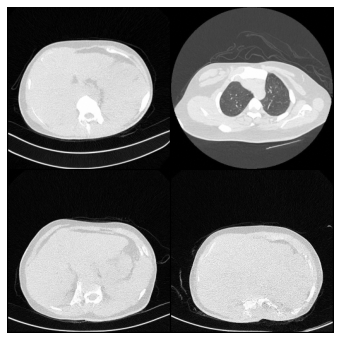

In [15]:
from torchvision.utils import make_grid
import tqdm
import torch

device = 'cuda' if torch.cuda.is_available() else "cpu"

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std_fn, channels=[32, 32, 64, 64, 64, 64, 64], embed_dim=256))
score_model = score_model.to(device)

# model load
epoch = 55
ckpt = torch.load(f'/content/drive/MyDrive/covid_ncsn_weights/ckpt_ema_{epoch}.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 4
sampler = pc_sampler

samples = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

samples = samples.clamp(-1.0, 1.0)
samples = (samples + 1.)/2.

%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()
# 단순 훈련

## Inverse Transformation Utils

In [16]:
import jax

import jax.numpy as jnp
import numpy as np
2
from math import ceil

__all__ = ['prod', 'resize']


def _normalize_axes(axes, ndim):
  if axes is None:
    return tuple(range(ndim))
  else:
    return tuple(a % ndim for a in sorted(axes))


def _normalize_shape(shape):
  if isinstance(shape, int):
    return (shape,)
  else:
    return tuple(shape)


def _expand_shapes(*shapes):
  shapes = [list(shape) for shape in shapes]
  max_ndim = max(len(shape) for shape in shapes)
  shapes_exp = [[1] * (max_ndim - len(shape)) + shape
                for shape in shapes]

  return tuple(shapes_exp)


def prod(shape):
  """Computes product of shape.
  Args:
      shape (tuple or list): shape.
  Returns:
      Product.
  """
  return np.prod(shape, dtype=np.int32)


def resize(input, oshape, ishift=None, oshift=None):
  """Resize with zero-padding or cropping.
  Args:
      input (array): Input array.
      oshape (tuple of ints): Output shape.
      ishift (None or tuple of ints): Input shift.
      oshift (None or tuple of ints): Output shift.
  Returns:
      array: Zero-padded or cropped result.
  """

  ishape1, oshape1 = _expand_shapes(input.shape, oshape)

  if ishape1 == oshape1:
    return input.reshape(oshape)

  if ishift is None:
    ishift = [max(i // 2 - o // 2, 0) for i, o in zip(ishape1, oshape1)]

  if oshift is None:
    oshift = [max(o // 2 - i // 2, 0) for i, o in zip(ishape1, oshape1)]

  copy_shape = [min(i - si, o - so)
                for i, si, o, so in zip(ishape1, ishift, oshape1, oshift)]
  islice = tuple([slice(si, si + c) for si, c in zip(ishift, copy_shape)])
  oslice = tuple([slice(so, so + c) for so, c in zip(oshift, copy_shape)])

  output = jnp.zeros(oshape1, dtype=input.dtype)
  input = input.reshape(ishape1)
  output = output.at[oslice].set(input[islice])

  return output.reshape(oshape)

In [17]:
KERNELS = ['spline', 'kaiser_bessel']


def interpolate(input, coord, kernel='spline', width=2, param=1):
  r"""Interpolation from array to points specified by coordinates.
  Let :math:`x` be the input, :math:`y` be the output,
  :math:`c` be the coordinates, :math:`W` be the kernel width,
  and :math:`K` be the interpolation kernel, then the function computes,
  .. math ::
      y[j] = \sum_{i : \| i - c[j] \|_\infty \leq W / 2}
             K\left(\frac{i - c[j]}{W / 2}\right) x[i]
  There are two types of kernels: 'spline' and 'kaiser_bessel'.
  'spline' uses the cardinal B-spline functions as kernels.
  The order of the spline can be specified using param.
  For example, param=1 performs linear interpolation.
  Concretely, for param=0, :math:`K(x) = 1`,
  for param=1, :math:`K(x) = 1 - |x|`, and
  for param=2, :math:`K(x) = \frac{9}{8} (1 - |x|)^2`
  for :math:`|x| > \frac{1}{3}`
  and :math:`K(x) = \frac{3}{4} (1 - 3 x^2)` for :math:`|x| < \frac{1}{3}`.
  These function expressions are derived from the reference wikipedia
  page by shifting and scaling the range to -1 to 1.
  When the coordinates specifies a uniformly spaced grid,
  it is recommended to use the original scaling with width=param + 1
  so that the interpolation weights add up to one.
  'kaiser_bessel' uses the Kaiser-Bessel function as kernel.
  Concretely, :math:`K(x) = I_0(\beta \sqrt{1 - x^2})`,
  where :math:`I_0` is the modified Bessel function of the first kind.
  The beta parameter can be specified with param.
  The modified Bessel function of the first kind is approximated
  using the power series, following the reference.
  Args:
      input (array): Input array of shape.
      coord (array): Coordinate array of shape [..., ndim]
      width (float or tuple of floats): Interpolation kernel full-width.
      kernel (str): Interpolation kernel, {'spline', 'kaiser_bessel'}.
      param (float or tuple of floats): Kernel parameter.
  Returns:
      output (array): Output array.
  References:
      https://en.wikipedia.org/wiki/Spline_wavelet#Cardinal_B-splines_of_small_orders
      http://people.math.sfu.ca/~cbm/aands/page_378.htm
  """
  ndim = coord.shape[-1]

  batch_shape = input.shape[:-ndim]
  batch_size = prod(batch_shape)

  pts_shape = coord.shape[:-1]
  npts = prod(pts_shape)

  input = input.reshape([batch_size] + list(input.shape[-ndim:]))
  coord = coord.reshape([npts, ndim])

  if np.isscalar(param):
    param = jnp.array([param] * ndim, coord.dtype)
  else:
    param = jnp.array(param, coord.dtype)

  if np.isscalar(width):
    width = np.array([width] * ndim, coord.dtype)
  else:
    width = np.array(width, coord.dtype)

  output = _interpolate[kernel][ndim - 1](input, coord, width, param)
  return output.reshape(batch_shape + pts_shape)


def _spline_kernel(x, order):
  if order == 0:
    return jnp.where(jnp.abs(x) > 1., 0., 1.)
  elif order == 1:
    return jnp.where(jnp.abs(x) > 1., 0., 1. - jnp.abs(x))
  elif order == 2:
    return jnp.where(jnp.abs(x) > 1., 0.,
                     jnp.where(jnp.abs(x) > 1 / 3,
                               9 / 8 * (1 - jnp.abs(x)) ** 2,
                               3 / 4 * (1 - 3 * x ** 2)))


def _kaiser_bessel_kernel(x, beta):
  xx = beta * (1. - x ** 2) ** 0.5
  t = xx / 3.75
  return jnp.where(jnp.abs(x) > 1., 0.,
                   jnp.where(xx < 3.75,
                             1 + 3.5156229 * t ** 2 + 3.0899424 * t ** 4 +
                             1.2067492 * t ** 6 + 0.2659732 * t ** 8 +
                             0.0360768 * t ** 10 + 0.0045813 * t ** 12,
                             xx ** -0.5 * jnp.exp(xx) * (
                                 0.39894228 + 0.01328592 * t ** -1 +
                                 0.00225319 * t ** -2 - 0.00157565 * t ** -3 +
                                 0.00916281 * t ** -4 - 0.02057706 * t ** -5 +
                                 0.02635537 * t ** -6 - 0.01647633 * t ** -7 +
                                 0.00392377 * t ** -8)
                             ))


def _get_interpolate(kernel):
  if kernel == 'spline':
    kernel = _spline_kernel
  elif kernel == 'kaiser_bessel':
    kernel = _kaiser_bessel_kernel

  def _interpolate1(input, coord, width, param):
    kx = coord[:, -1]
    x0 = jnp.ceil(kx - width[-1] / 2).astype(jnp.int32)
    x_range = x0[:, None] + jnp.arange(0, width[-1], dtype=jnp.int32)[None, :]
    w = kernel((x_range - kx[:, None]) / (width[-1] / 2), param[-1])
    input = jnp.take(input, x_range, axis=1, mode='wrap')
    output = jnp.sum(w * input, axis=2)

    return output

  def _interpolate2(input, coord, width, param):

    batch_size, ny, nx = input.shape

    kx = coord[:, -1]
    ky = coord[:, -2]
    x0 = jnp.ceil(kx - width[-1] / 2).astype(jnp.int32)
    y0 = jnp.ceil(ky - width[-2] / 2).astype(jnp.int32)
    arange_x = jnp.arange(0, width[-1], dtype=jnp.int32)
    arange_y = jnp.arange(0, width[-2], dtype=jnp.int32)
    x_range = x0[:, None] + arange_x[None, :]
    y_range = y0[:, None] + arange_y[None, :]

    wy = kernel((y_range - ky[:, None]) / (width[-2] / 2), param[-2])
    wx = kernel((x_range - kx[:, None]) / (width[-1] / 2), param[-1])
    w = wy[:, :, None] * wx[:, None, :]

    x_mesh, y_mesh = jnp.meshgrid(arange_x, arange_y, indexing='xy')
    x_mesh_range = (x0[:, None, None] + x_mesh) % nx
    y_mesh_range = (y0[:, None, None] + y_mesh) % ny

    input = input[:, y_mesh_range, x_mesh_range]

    return jnp.sum(w * input, axis=(2, 3))

  def _interpolate3(input, coord, width, param):
    batch_size, nz, ny, nx = input.shape

    kx = coord[:, -1]
    ky = coord[:, -2]
    kz = coord[:, -3]

    x0 = jnp.ceil(kx - width[-1] / 2).astype(jnp.int32)
    y0 = jnp.ceil(ky - width[-2] / 2).astype(jnp.int32)
    z0 = jnp.ceil(kz - width[-3] / 2).astype(jnp.int32)

    arange_x = jnp.arange(0, width[-1], dtype=jnp.int32)
    arange_y = jnp.arange(0, width[-2], dtype=jnp.int32)
    arange_z = jnp.arange(0, width[-3], dtype=jnp.int32)

    x_range = x0[:, None] + arange_x[None, :]
    y_range = y0[:, None] + arange_y[None, :]
    z_range = z0[:, None] + arange_z[None, :]

    wz = kernel((z_range - kz[:, None]) / (width[-3] / 2), param[-3])
    wy = kernel((y_range - ky[:, None]) / (width[-2] / 2), param[-2])
    wx = kernel((x_range - kx[:, None]) / (width[-1] / 2), param[-1])
    w = wz[:, :, None, None] * wy[:, None, :, None] * wx[:, None, None, :]

    z_mesh, y_mesh, x_mesh = jnp.meshgrid(arange_z, arange_y, arange_x, indexing='ij')
    x_mesh_range = (x0[:, None, None, None] + x_mesh) % nx
    y_mesh_range = (y0[:, None, None, None] + y_mesh) % ny
    z_mesh_range = (z0[:, None, None, None] + z_mesh) % nz

    input = input[:, z_mesh_range, y_mesh_range, x_mesh_range]

    return jnp.sum(w * input, axis=(2, 3, 4))

  return _interpolate1, _interpolate2, _interpolate3


def gridding(input, coord, shape, kernel="spline", width=2, param=1):
  r"""Gridding of points specified by coordinates to array.
  Let :math:`y` be the input, :math:`x` be the output,
  :math:`c` be the coordinates, :math:`W` be the kernel width,
  and :math:`K` be the interpolation kernel, then the function computes,
  .. math ::
      x[i] = \sum_{j : \| i - c[j] \|_\infty \leq W / 2}
             K\left(\frac{i - c[j]}{W / 2}\right) y[j]
  There are two types of kernels: 'spline' and 'kaiser_bessel'.
  'spline' uses the cardinal B-spline functions as kernels.
  The order of the spline can be specified using param.
  For example, param=1 performs linear interpolation.
  Concretely, for param=0, :math:`K(x) = 1`,
  for param=1, :math:`K(x) = 1 - |x|`, and
  for param=2, :math:`K(x) = \frac{9}{8} (1 - |x|)^2`
  for :math:`|x| > \frac{1}{3}`
  and :math:`K(x) = \frac{3}{4} (1 - 3 x^2)` for :math:`|x| < \frac{1}{3}`.
  These function expressions are derived from the reference wikipedia
  page by shifting and scaling the range to -1 to 1.
  When the coordinates specifies a uniformly spaced grid,
  it is recommended to use the original scaling with width=param + 1
  so that the interpolation weights add up to one.
  'kaiser_bessel' uses the Kaiser-Bessel function as kernel.
  Concretely, :math:`K(x) = I_0(\beta \sqrt{1 - x^2})`,
  where :math:`I_0` is the modified Bessel function of the first kind.
  The beta parameter can be specified with param.
  The modified Bessel function of the first kind is approximated
  using the power series, following the reference.
  Args:
      input (array): Input array.
      coord (array): Coordinate array of shape [..., ndim]
      width (float or tuple of floats): Interpolation kernel full-width.
      kernel (str): Interpolation kernel, {"spline", "kaiser_bessel"}.
      param (float or tuple of floats): Kernel parameter.
  Returns:
      output (array): Output array.
  References:
      https://en.wikipedia.org/wiki/Spline_wavelet#Cardinal_B-splines_of_small_orders
      http://people.math.sfu.ca/~cbm/aands/page_378.htm
  """
  ndim = coord.shape[-1]

  batch_shape = shape[:-ndim]
  batch_size = prod(batch_shape)

  pts_shape = coord.shape[:-1]
  npts = prod(pts_shape)

  input = input.reshape([batch_size, npts])
  coord = coord.reshape([npts, ndim])
  output = jnp.zeros([batch_size] + list(shape[-ndim:]), dtype=input.dtype)

  if np.isscalar(param):
    param = np.array([param] * ndim, coord.dtype)
  else:
    param = np.array(param, coord.dtype)

  if np.isscalar(width):
    width = np.array([width] * ndim, coord.dtype)
  else:
    width = np.array(width, coord.dtype)

  output = _gridding[kernel][ndim - 1](output, input, coord, width, param)

  return output.reshape(shape)


def _get_gridding(kernel):
  if kernel == 'spline':
    kernel = _spline_kernel
  elif kernel == 'kaiser_bessel':
    kernel = _kaiser_bessel_kernel

  interpolate1, interpolate2, interpolate3 = _get_interpolate(kernel)

  # implementing transposed convolutions with gradients
  def _gridding1(output, input, coord, width, param):
    def helper(output, input):
      value = interpolate1(output, coord, width, param)
      value = jnp.sum(value * input)
      return value

    grad_fn = jax.grad(helper, argnums=0)
    return grad_fn(output.real, input.real) + 1j * grad_fn(output.imag, input.imag)

  def _gridding2(output, input, coord, width, param):
    def helper(output, input):
      value = interpolate2(output, coord, width, param)
      value = jnp.sum(value * input)
      return value

    grad_fn = jax.grad(helper, argnums=0)
    return grad_fn(output.real, input.real) + 1j * grad_fn(output.imag, input.imag)

  def _gridding3(output, input, coord, width, param):
    def helper(output, input):
      value = interpolate3(output, coord, width, param)
      value = jnp.sum(value * input)
      return value

    grad_fn = jax.grad(helper, argnums=0)
    return grad_fn(output.real, input.real) + 1j * grad_fn(output.imag, input.imag)

  return _gridding1, _gridding2, _gridding3


_interpolate = {}
_gridding = {}
for kernel in KERNELS:
  _interpolate[kernel] = _get_interpolate(kernel)
  _gridding[kernel] = _get_gridding(kernel)

In [18]:


__all__ = ['fft', 'ifft', 'nufft']


def fft(input, oshape=None, axes=None, center=True, norm=None):
  """FFT function that supports centering.
  Args:
      input (array): input array.
      oshape (None or array of ints): output shape.
      axes (None or array of ints): Axes over which to compute the FFT.
      norm (None or ``"ortho"``): Keyword to specify the normalization mode.
  Returns:
      array: FFT result of dimension oshape.
  See Also:
      :func:`numpy.fft.fftn`
  """
  if not np.issubdtype(input.dtype, jnp.complexfloating):
    input = input.astype(jnp.complex64)

  if center:
    output = _fftc(input, oshape=oshape, axes=axes, norm=norm)
  else:
    output = jnp.fft.fftn(input, s=oshape, axes=axes, norm=norm)

  if np.issubdtype(input.dtype,
                   jnp.complexfloating) and input.dtype != output.dtype:
    output = output.astype(input.dtype, copy=False)

  return output


def ifft(input, oshape=None, axes=None, center=True, norm=None):
  """IFFT function that supports centering.
  Args:
      input (array): input array.
      oshape (None or array of ints): output shape.
      axes (None or array of ints): Axes over which to compute
          the inverse FFT.
      norm (None or ``"ortho"``): Keyword to specify the normalization mode.
  Returns:
      array of dimension oshape.
  See Also:
      :func:`numpy.fft.ifftn`
  """
  if not np.issubdtype(input.dtype, jnp.complexfloating):
    input = input.astype(jnp.complex64)

  if center:
    output = _ifftc(input, oshape=oshape, axes=axes, norm=norm)
  else:
    output = jnp.fft.ifftn(input, s=oshape, axes=axes, norm=norm)

  if np.issubdtype(input.dtype,
                   jnp.complexfloating) and input.dtype != output.dtype:
    output = output.astype(input.dtype)

  return output


def nufft(input, coord, oversamp=1.25, width=4):
  """Non-uniform Fast Fourier Transform.
  Args:
      input (array): input signal domain array of shape
          (..., n_{ndim - 1}, ..., n_1, n_0),
          where ndim is specified by coord.shape[-1]. The nufft
          is applied on the last ndim axes, and looped over
          the remaining axes.
      coord (array): Fourier domain coordinate array of shape (..., ndim).
          ndim determines the number of dimensions to apply the nufft.
          coord[..., i] should be scaled to have its range between
          -n_i // 2, and n_i // 2.
      oversamp (float): oversampling factor.
      width (float): interpolation kernel full-width in terms of
          oversampled grid.
      n (int): number of sampling points of the interpolation kernel.
  Returns:
      array: Fourier domain data of shape
          input.shape[:-ndim] + coord.shape[:-1].
  References:
      Fessler, J. A., & Sutton, B. P. (2003).
      Nonuniform fast Fourier transforms using min-max interpolation
      IEEE Transactions on Signal Processing, 51(2), 560-574.
      Beatty, P. J., Nishimura, D. G., & Pauly, J. M. (2005).
      Rapid gridding reconstruction with a minimal oversampling ratio.
      IEEE transactions on medical imaging, 24(6), 799-808.
  """
  ndim = coord.shape[-1]
  beta = np.pi * (((width / oversamp) * (oversamp - 0.5)) ** 2 - 0.8) ** 0.5
  os_shape = _get_oversamp_shape(input.shape, ndim, oversamp)

  # Apodize
  output = _apodize(input, ndim, oversamp, width, beta)

  # Zero-pad
  output /= prod(input.shape[-ndim:]) ** 0.5
  output = resize(output, os_shape)

  # FFT
  output = fft(output, axes=range(-ndim, 0), norm=None)

  # Interpolate
  coord = _scale_coord(coord, input.shape, oversamp)
  output = interpolate(output, coord, kernel='kaiser_bessel', width=width, param=beta)
  output /= width ** ndim

  return output


def nufft_adjoint(input, coord, oshape, oversamp=1.25, width=4):
  """Adjoint non-uniform Fast Fourier Transform.
  Args:
      input (array): input Fourier domain array of shape
          (...) + coord.shape[:-1]. That is, the last dimensions
          of input must match the first dimensions of coord.
          The nufft_adjoint is applied on the last coord.ndim - 1 axes,
          and looped over the remaining axes.
      coord (array): Fourier domain coordinate array of shape (..., ndim).
          ndim determines the number of dimension to apply nufft adjoint.
          coord[..., i] should be scaled to have its range between
          -n_i // 2, and n_i // 2.
      oshape (tuple of ints): output shape of the form
          (..., n_{ndim - 1}, ..., n_1, n_0).
      oversamp (float): oversampling factor.
      width (float): interpolation kernel full-width in terms of
          oversampled grid.
      n (int): number of sampling points of the interpolation kernel.
  Returns:
      array: signal domain array with shape specified by oshape.
  See Also:
      :func:`sigpy.nufft.nufft`
  """
  ndim = coord.shape[-1]
  beta = np.pi * (((width / oversamp) * (oversamp - 0.5)) ** 2 - 0.8) ** 0.5
  oshape = list(oshape)

  os_shape = _get_oversamp_shape(oshape, ndim, oversamp)

  # Gridding
  coord = _scale_coord(coord, oshape, oversamp)
  output = gridding(input, coord, os_shape,
                           kernel='kaiser_bessel', width=width, param=beta)
  # import sigpy
  # output = sigpy.interp.gridding(np.array(input), np.array(coord), os_shape,
  #                                kernel='kaiser_bessel', width=width, param=beta)
  output /= width ** ndim

  # IFFT
  output = ifft(output, axes=range(-ndim, 0), norm=None)

  # Crop
  output = resize(output, oshape)
  output *= prod(os_shape[-ndim:]) / prod(oshape[-ndim:]) ** 0.5

  # Apodize
  output = _apodize(output, ndim, oversamp, width, beta)

  return output


def _fftc(input, oshape=None, axes=None, norm=None):
  ndim = input.ndim
  axes = _normalize_axes(axes, ndim)

  if oshape is None:
    oshape = input.shape

  tmp = resize(input, oshape)
  tmp = jnp.fft.ifftshift(tmp, axes=axes)
  tmp = jnp.fft.fftn(tmp, axes=axes, norm=norm)
  output = jnp.fft.fftshift(tmp, axes=axes)
  return output


def _ifftc(input, oshape=None, axes=None, norm=None):
  ndim = input.ndim
  axes = _normalize_axes(axes, ndim)

  if oshape is None:
    oshape = input.shape

  tmp = resize(input, oshape)
  tmp = jnp.fft.ifftshift(tmp, axes=axes)
  tmp = jnp.fft.ifftn(tmp, axes=axes, norm=norm)
  output = jnp.fft.fftshift(tmp, axes=axes)
  return output


def _scale_coord(coord, shape, oversamp):
  ndim = coord.shape[-1]
  scale = np.ceil(oversamp * np.array(shape[-ndim:])) / shape[-ndim:]
  shift = np.ceil(oversamp * np.array(shape[-ndim:])) // 2
  return coord * scale + shift


def _get_oversamp_shape(shape, ndim, oversamp):
  return list(shape)[:-ndim] + [ceil(oversamp * i) for i in shape[-ndim:]]


def _apodize(input, ndim, oversamp, width, beta):
  output = input
  for a in range(-ndim, 0):
    i = output.shape[a]
    os_i = ceil(oversamp * i)
    idx = np.arange(i, dtype=output.dtype)

    # Calculate apodization
    apod = (beta ** 2 - (np.pi * width * (idx - i // 2) / os_i) ** 2) ** 0.5
    apod /= np.sinh(apod)
    output *= apod.reshape([i] + [1] * (-a - 1))

  return output


def estimate_shape(coord):
  """Estimate array shape from coordinates.
  Shape is estimated by the different between maximum and minimum of
  coordinates in each axis.
  Args:
      coord (array): Coordinates.
  """
  ndim = coord.shape[-1]
  shape = [int(coord[..., i].max() - coord[..., i].min())
           for i in range(ndim)]

  return shape

In [19]:
import math

__all__ = ['radon_transform', 'iradon_transform']

def expand_diameter(diameter, K):
  expanded_diameter = int(diameter * K)
  if expanded_diameter % 2 == 1:
    expanded_diameter += 1
  return expanded_diameter


def get_r_coords(diameter, num):
  if diameter % 2 == 0:
    radius = diameter / 2 - 0.5
    center = -0.5
    return np.linspace(-radius, radius, num) + center
  else:
    radius = (diameter - 1) / 2
    return np.linspace(-radius, radius, num)



def get_kspace_radial(diameter, expanded_diameter, n_projections):
  r = get_r_coords(diameter, expanded_diameter)
  a = np.linspace(0, np.pi, n_projections, endpoint=False)
  r_grid, a_grid = np.meshgrid(r, a, indexing='xy')
  x = np.round((r_grid * np.cos(a_grid)) * expanded_diameter / diameter) % expanded_diameter
  y = np.round((-r_grid * np.sin(a_grid)) * expanded_diameter / diameter) % expanded_diameter
  return x.astype(np.int32), y.astype(np.int32)


def get_ct_mask(size, n_angles, expansion):
  diameter = math.ceil(np.sqrt(2.) * size)
  expanded_diameter = expand_diameter(diameter, expansion)
  x, y = get_kspace_radial(diameter, expanded_diameter, n_angles)
  return jnp.zeros((expanded_diameter, expanded_diameter)).at[y, x].set(1.)


def get_ct_subsampling_mask(size, n_angles, expansion):
  diameter = math.ceil(np.sqrt(2.) * size)
  expanded_diameter = expand_diameter(diameter, expansion)
  sampled_row_ids = np.round(np.linspace(0, size - 1, n_angles)).astype(np.int32)
  return jnp.zeros((size, expanded_diameter)).at[sampled_row_ids, :].set(1.)



In [20]:
import matplotlib.pyplot as plt



def get_cartesian_mask(shape, n_keep=30):
  # shape [Tuple]: (H, W)
  size = shape[0]
  center_fraction = n_keep / 1000
  acceleration = size / n_keep

  num_rows, num_cols = shape[0], shape[1]
  num_low_freqs = int(round(num_cols * center_fraction))

  # create the mask
  mask = np.zeros((num_rows, num_cols), dtype=np.float32)
  pad = (num_cols - num_low_freqs + 1) // 2
  mask[:, pad: pad + num_low_freqs] = True

  # determine acceleration rate by adjusting for the number of low frequencies
  adjusted_accel = (acceleration * (num_low_freqs - num_cols)) / (
      num_low_freqs * acceleration - num_cols
  )

  offset = round(adjusted_accel) // 2

  accel_samples = np.arange(offset, num_cols - 1, adjusted_accel)
  accel_samples = np.around(accel_samples).astype(np.uint32)
  mask[:, accel_samples] = True

  return mask


def get_cartesian_mask_coordinates(size, n_keep):
  i, j = np.nonzero(get_cartesian_mask((size, size), n_keep))
  y_grid = i.reshape((n_keep, -1))
  x_grid = j.reshape((n_keep, -1))
  return x_grid, y_grid


    # training
    

def get_masks():
    mask = get_ct_subsampling_mask(size=256, n_angles=23, expansion=4)[None, ..., None]
    return mask



In [21]:
def pad_image(image):# shape : batch_size, c, h, w
  diagonal = np.sqrt(2) * max(image.shape[-2:])
  pad = [int(np.ceil(diagonal - s)) for s in image.shape[-2:]]
  new_center = [(s + p) // 2 for s, p in zip(image.shape[-2:], pad)]
  old_center = [s // 2 for s in image.shape[-2:]]
  pad_before = [nc - oc for oc, nc in zip(old_center, new_center)]
  pad_width = [(pb, p - pb) for pb, p in zip(pad_before, pad)]
  pad_width = [(0, 0) for i in image.shape[:-2]] + pad_width
  padded_image = jnp.pad(image, pad_width, mode='constant',
                         constant_values=0)
  return padded_image

def fft_discretize_sinogram(image, sino, expansion=8):
  image = pad_image(image)
  diameter = image.shape[-1]
  expanded_diameter = expand_diameter(diameter, expansion)
  r = get_r_coords(diameter, expanded_diameter)
  N = sino.shape[-2]
  a = np.linspace(0, np.pi, N, endpoint=False)
  r_grid, a_grid = np.meshgrid(r, a, indexing='xy')

  circle_y = -r_grid * np.sin(a_grid)
  circle_x = r_grid * np.cos(a_grid)

  round_y = np.round(circle_y * expanded_diameter / diameter) * diameter / expanded_diameter
  round_x = np.round(circle_x * expanded_diameter / diameter) * diameter / expanded_diameter
  round_z = round_x - 1j * round_y
  round_r = np.abs(round_z)
  round_theta = np.angle(round_z)
  round_r = np.where(round_theta < 0, -round_r, round_r)
  round_theta = np.where(round_theta < 0, round_theta + np.pi, round_theta)

  x = np.round((r_grid * np.cos(a_grid)) * expanded_diameter / diameter) % expanded_diameter
  y = np.round((-r_grid * np.sin(a_grid)) * expanded_diameter / diameter) % expanded_diameter

  slices = nufft(sino, r[:, None], oversamp=1.25, width=4) * np.sqrt(diameter)
  round_theta = (round_theta - a.min()) / (a.max() - a.min()) * (N - 1)
  round_r = (round_r - r.min()) / (r.max() - r.min()) * (expanded_diameter - 1)

  def interp_slices(slices):
    slices = jax.scipy.ndimage.map_coordinates(slices,
                                               np.stack([round_theta, round_r],
                                                        axis=0),
                                               order=1, mode='nearest')
    slices = slices.reshape(round_theta.shape)
    return slices

  slices = jax.vmap(interp_slices)(slices)
  oshape = image.shape[:-2] + (expanded_diameter, expanded_diameter)
  
  kspace = jnp.zeros(oshape, dtype=jnp.complex64).at[..., y.astype(jnp.int32),
                                                     x.astype(jnp.int32)].set(slices)
  return kspace


def radon_transform(image, N=50):
  K = 1.25
  oversamp = 1.25
  width = 4
  image = pad_image(image)
  diameter = image.shape[-1]
  expanded_diameter = expand_diameter(diameter, K)
  r = get_r_coords(diameter, expanded_diameter)
  a = np.linspace(0, np.pi, N, endpoint=False)
  r_grid, a_grid = np.meshgrid(r, a, indexing='xy')
  x = r_grid * np.cos(a_grid)
  y = -r_grid * np.sin(a_grid)

  kspace = nufft(image, jnp.stack([y, x], axis=-1), oversamp=oversamp, width=width)
  sinogram = nufft_adjoint(kspace, r[:, None], oshape=kspace.shape[:-1] + (diameter,),
                                   oversamp=oversamp, width=width) * diameter / expanded_diameter / np.sqrt(diameter)
  return sinogram.real * diameter



def fft_radon_transform(image, N=50, expansion=6):
  image = pad_image(image)
  diameter = image.shape[-1]
  expanded_diameter = expand_diameter(diameter, expansion)
  x, y = get_kspace_radial(diameter, expanded_diameter, N)
  oshape = image.shape[:-2] + (expanded_diameter, expanded_diameter)
  image = resize(image, oshape)
  kspace = jnp.fft.fft2(jnp.fft.ifftshift(image, axes=(-2, -1)), axes=(-2, -1))
  slices = kspace[..., y.astype(jnp.int32), x.astype(jnp.int32)]
  sinogram = jnp.fft.fftshift(jnp.fft.ifft(jnp.fft.ifftshift(slices, axes=-1), axis=-1), axes=-1)
  # oshape = sinogram.shape[:-1] + (diameter,)
  # sinogram = util.resize(sinogram, oshape)
  return sinogram


"""
    image -> kspace : fft_radon_to_kspace
    kspace -> sino : fft_kspace_to_sino
    sino -> kspace : fft_sino_to_kspace
    kspace -> image : fft_radon_to_image
"""


def unpad_image(image): # image
  size = int(np.sqrt(image.shape[-1] ** 2 / 2)) # image.shape[-1] ** 2 / 2
  pad_left = (image.shape[-1] - size) // 2
  return image[..., pad_left:pad_left + size, pad_left:pad_left + size]


def fft_radon_to_kspace(image, expansion=4):
  image = pad_image(image)
  diameter = image.shape[-1]
  expanded_diameter = expand_diameter(diameter, expansion)

  oshape = image.shape[:-2] + (expanded_diameter, expanded_diameter)
  image = resize(image, oshape)
  kspace = jnp.fft.fft2(jnp.fft.ifftshift(image, axes=(-2, -1)), axes=(-2, -1))
  return kspace




# image -> kspace -> sino
# sino -> kspace -> image
def fft_radon_to_image(kspace, size):
  image = jnp.fft.fftshift(jnp.fft.ifft2(kspace, axes=(-2, -1)), axes=(-2, -1))
  diagonal = math.ceil(np.sqrt(2) * size)
  oshape = image.shape[:-2] + (diagonal, diagonal)
  image = resize(image, oshape)
  return unpad_image(image.real)


def fft_kspace_to_sino(kspace, n_projections, size, expansion):
  diameter = math.ceil(np.sqrt(2.) * size)
  expanded_diameter = expand_diameter(diameter, expansion)
  x, y = get_kspace_radial(diameter, expanded_diameter, n_projections)

  slices = kspace[..., y.astype(jnp.int32), x.astype(jnp.int32)]
  sinogram = jnp.fft.fftshift(jnp.fft.ifft(jnp.fft.ifftshift(slices, axes=-1), axis=-1), axes=-1)
  # oshape = sinogram.shape[:-1] + (diameter,)
  # return util.resize(sinogram, oshape)
  return sinogram


def fft_sino_to_kspace(sino, n_projections, size, expansion):
  diameter = math.ceil(np.sqrt(2.) * size)
  expanded_diameter = expand_diameter(diameter, expansion)
  x, y = get_kspace_radial(diameter, expanded_diameter, n_projections)

  # oshape = sino.shape[:-2] + (n_projections, expanded_diameter)
  # sino = util.resize(sino, oshape)
  slices = jnp.fft.fftshift(jnp.fft.fft(jnp.fft.ifftshift(sino, axes=-1), axis=-1), axes=-1)
  oshape = sino.shape[:-2] + (expanded_diameter, expanded_diameter)
  kspace = jnp.zeros(oshape, dtype=jnp.complex64).at[..., y.astype(jnp.int32), x.astype(jnp.int32)].set(slices)
  return kspace


def get_known(img): # sinogram .
    # sinogram의 n_projections를 image size와 동일하게 가져가야합니다. -> 더 낮은 projection 설정으로 transformation하면 information이 소실됩니다. 때문에 제대로 information injection이 안됩니다.
    n_projections = 256
    sinogram = radon_transform(img[..., 0], n_projections)
    known = fft_discretize_sinogram(img[..., 0], sinogram, expansion=4)
    return known[..., None]

def merge_known_with_mask(x_space, known, mask, coeff=1.):
    size = 256
    expansion = 4
    x_sino = fft_kspace_to_sino(x_space[..., 0], size, size, expansion)[..., None]
    known_sino = fft_kspace_to_sino(known[..., 0], size, size, expansion)[..., None]
    merged_sino = x_sino * (1. - mask * coeff) + known_sino * mask * coeff
    merged_kspace = fft_sino_to_kspace(merged_sino[..., 0], size, size, expansion)[..., None]
    ct_mask = get_ct_mask(size, size, expansion)[None, ..., None]
    merged_kspace = merged_kspace * ct_mask + x_space * (1. - ct_mask)
    return merged_kspace




## Partial Measurement Information을 사용한 Sampling

In [22]:
from PIL import Image

def marginal_prob_std_np(t, sigma_min=0.01, sigma_max=50.0): # VE SDE
    return sigma_min*np.exp(t * (np.log(sigma_max) - np.log(sigma_min)))

# sampling -> PC collector.

# 1. Numerical SDE Solvers

"""
    dx = f(x,t)dt + g(t)dw
    reverse.
    dx = [f(x,t)- g(t)^2*score]dt + g(t)dw
    dx = g(t) dw 식이 있음. (현재 상황과 대응되는. VE, VP,..) .
    -> so, dx = -g(t)^2 * scoredt + g(t)dw

    timestep 들에 대해 sampling을 움직임.
    즉. 
    x_{t-small_t} = x_t + g(t)^2* score_model(x_t,t) + g(t)*sqrt(small_t)*z_t
    (z_t ~ N(0,1))

    이 방법이 Numerical Methods. Euler-Maruyama approach
\
"""

signal_to_noise_ratio = 0.246
## The number of sampling steps.
num_steps =  1000


def get_images(num, path):
    files = os.listdir(path)[:num]
    files = [os.path.join(path, f) for f in files]
    images = [[(np.array(Image.open(f).resize((256,256))).astype(np.float32) / 255. * 2) - 1] for f in files]
    return np.expand_dims(np.concatenate(images, axis=0), 3)


def merge(x, known, mask, np_batch_time_step, to_space, from_space, coeff=0.841):

    # 2. disturb y (t 만큼.) -> y' (known)
    z = np.random.randn(*x.shape)
    
    z = to_space(z)

    std = marginal_prob_std_np(np_batch_time_step)
    noisy_known = known + z * std[:, None, None, None]

    x = x.permute(0,2,3,1).detach().cpu().numpy() # bs, c, h ,w -> bs, h, w, c numpy array

    # 3. inter_op =  coef * mask * y'' + (1-coef) * mask * x_sino + (1 - mask) * x_sino
    

    x_space = to_space(x)
    # coef에 대해 merge. output은 kspace.
    merged = merge_known_with_mask(x_space, noisy_known, mask, coeff=coeff)
    x = from_space(merged).__array__()
    

    x = torch.from_numpy(x).to(device).permute(0, 3, 1, 2) # bs, h, w, c -> bs, c, h, w tensor gpu

    return x


def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=64,
               num_steps=num_steps,
               snr=signal_to_noise_ratio,
               device='cuda',
               eps=1e-5):
    
    to_space = lambda x: fft_radon_to_kspace(x[..., 0], 4)[..., None] # 4 : expansion
    from_space = lambda x: fft_radon_to_image(x[..., 0], 256)[..., None] # 256 : imagesize
    # torch.cuda.empty_cache()
    y = get_images(batch_size, path="/content/datas")  # (num, h, w ,c) numpy
    print(y.shape)
    
    known = get_known(y).__array__() # sinogram numpy array
    mask = get_masks() # mask

    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, 1, 256, 256, device=device) * marginal_prob_std(t)[:, None, None, None]
    time_steps = np.linspace(1., eps, num_steps) # 1 ~ eps 점점 내려간다. 1이 완전 파괴된 경우.
    step_size = time_steps[0] - time_steps[1] # i/N
    x = init_x

    coeff = 0.841
    i = 0

    outputs = [x]
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            # noise를 걷어내는 중. x_T -> y_T로 time을 맞춰줘야한다. 현재 for문의 timestep을 사용하면 time이 대응되지 않는다.
            i += 1
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            np_batch_time_step = np.ones((batch_size)) * time_step

            if i == num_steps :
                coeff = 1.
                print(coeff)
            # y information injection.
            # y load (As much as the given batch size.) 79 line.

            # 1. make y (partial measurement) -> radon transformation
            # image -> ksp -> sino

            # Corrector 1 : 1 로 실행시킨다 Predictor Corrector.
            x = merge(x, known, mask, np_batch_time_step, to_space, from_space, coeff)

            grad = score_model(x, batch_time_step)
            grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
            noise_norm = np.sqrt(np.prod(x.shape[1:]))
            langevin_step_size = 2 * (snr * noise_norm / grad_norm) ** 2 # 원래는 sigma 가지고 step 조정하는데, 여기에선 gradient, noise 크기로 조정한다. 이에 대해서도 좀 공부해야할듯.
            x_mean = x + langevin_step_size * grad
            x = x_mean + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)

            # P
            x = merge(x, known, mask, np_batch_time_step, to_space, from_space, coeff)
            g = diffusion_coeff(batch_time_step)
            
            x_mean = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step) * step_size
            x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)

            # torch.cuda.empty_cache()
            if i % 50 == 0 :
                outputs.append(x)

    return x, outputs


(4, 256, 256, 1)


/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:1833: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "array")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3722: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


1.0


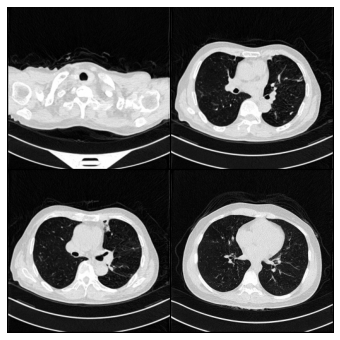

In [24]:
import os
from torchvision.utils import make_grid
import tqdm
import torch
"""
    Denoising 적용 안했을때.
"""


device = 'cuda' if torch.cuda.is_available() else "cpu"

score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std_fn, channels=[32, 32, 64, 64, 64, 64, 64], embed_dim=256))
# score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

epoch = 70
ckpt = torch.load(f'/content/drive/MyDrive/covid_ncsn_weights/ckpt_ema_{epoch}.pth', map_location=device)
score_model.load_state_dict(ckpt)

sample_batch_size = 4
sampler = pc_sampler

samples, outputs = sampler(score_model, 
                  marginal_prob_std_fn,
                  diffusion_coeff_fn, 
                  sample_batch_size, 
                  device=device)

samples = samples.clamp(-1.0, 1.0)
samples = (samples + 1) /2
# 좀 더 훈련시켜보자.
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

## 사용한 데이터

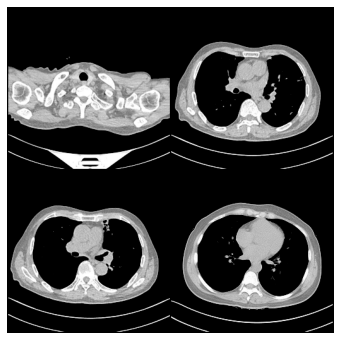

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

def get_tensor_images(num, path):
    files = os.listdir(path)[:num]
    files = [os.path.join(path, f) for f in files]
    images = [torch.tensor((np.array(Image.open(f).resize((256,256))) / 255. * 2) - 1) for f in files]
    return torch.stack(images, dim=0).unsqueeze(1)

samples = get_tensor_images(4, path="/content/datas")
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()